In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pandas numpy torch torch-geometric scikit-learn matplotlib optuna tensorflow keras-tuner scipy tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
import pandas as pd
import numpy as np
import torch
import gc
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import optuna
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from scipy.spatial import cKDTree
from torch_geometric.nn import SAGEConv
import torch.optim as optim
from tqdm import tqdm
from tensorflow.keras.models import load_model
import os

file_path = '/content/drive/MyDrive/THESIS/Train_model_Paris_Vince.csv'
full_train_data = pd.read_csv(file_path)


file_path = '/content/drive/MyDrive/THESIS/Valid_model_Paris_Vince.csv'
full_valid_data = pd.read_csv(file_path)


file_path = '/content/drive/MyDrive/THESIS/Test_model_Paris_Vince.csv'
full_test_data = pd.read_csv(file_path)

In [ ]:
train_data = full_train_data.copy()
val_data = full_valid_data.copy()
test_data = full_test_data.copy()

# Preprocess function
def preprocess_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    return data

train_data = preprocess_data(train_data)
val_data = preprocess_data(val_data)
test_data = preprocess_data(test_data)

In this step, the data is preprocessed for the PE-GNN model. Since historical prices are no longer needed, only one data entry is kept for each unique Airbnb listing. The coordinates are then extracted to be used in the position encoder, and the other hedonic features are combined with the learned LSTM features to be added to the nodes of the GNN. Additionally, it is ensured that the spatial and temporal features, which are used for the baseline models, are removed from the data

In [ ]:
import pandas as pd

# Preprocess PE-GNN data and take the last instance for each id
def preprocess_pegnn_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    data = data.drop_duplicates(subset=['id'], keep='last')
    return data

train_data_pegnn = preprocess_pegnn_data(train_data.copy())
val_data_pegnn = preprocess_pegnn_data(val_data.copy())
test_data_pegnn = preprocess_pegnn_data(test_data.copy())



In [ ]:
# Extract features
def extract_features(data):
    coordinates = data[['latitude', 'longitude']].to_numpy()
    # Dropping unnecessary columns including the specified features
    #features = data
    features = data.drop(columns=[
    'latitude', 'longitude', 'date', 'id', 'host_id',
    #'weekday', 'month', 'day',
    'is_holiday', 'is_school_holiday', 'season_Autumn', 'season_Winter', 'neighbourhood_Batignolles-Monceau',
    'neighbourhood_Bourse', 'neighbourhood_Buttes-Chaumont', 'neighbourhood_Buttes-Montmartre',
    'neighbourhood_Entrepôt', 'neighbourhood_Gobelins', 'neighbourhood_Hôtel-de-Ville',
    'neighbourhood_Louvre', 'neighbourhood_Luxembourg', 'neighbourhood_Ménilmontant',
    'neighbourhood_Observatoire', 'neighbourhood_Opéra', 'neighbourhood_Palais-Bourbon',
    'neighbourhood_Panthéon', 'neighbourhood_Passy', 'neighbourhood_Popincourt',
    'neighbourhood_Reuilly', 'neighbourhood_Temple', 'neighbourhood_Vaugirard',
    'neighbourhood_Élysée',
    #'Eiffel Tower Distance', 'Louvre Museum Distance', 'Notre-Dame Cathedral Distance', 'Sacré-Cœur Basilica Distance', 'Arc de Triomphe Distance',
    'nearby_airbnbs_count', 'nearby_restaurants_bars', 'nearby_transport', 'mean_price_neighbors'
    ])

    for col in features.select_dtypes(include=['object']).columns:
        features[col] = features[col].astype('category').cat.codes
    features = features.apply(pd.to_numeric, errors='coerce').fillna(0)
    features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
    non_numeric_cols = features.select_dtypes(exclude=[np.number]).columns.tolist()
    features = features.select_dtypes(include=[np.number])
    print("Dropped non-numeric features:", non_numeric_cols)

    features.columns = features.columns.astype(str)
    return coordinates, features



# Extracting features for train, validation, and test sets
train_coords_pegnn, train_features_pegnn = extract_features(train_data_pegnn)
val_coords_pegnn, val_features_pegnn = extract_features(val_data_pegnn)
test_coords_pegnn, test_features_pegnn = extract_features(test_data_pegnn)

train_prices_pegnn = train_features_pegnn['price'].values
val_prices_pegnn = val_features_pegnn['price'].values
test_prices_pegnn = test_features_pegnn['price'].values



# Scaling combined features
scaler = RobustScaler()
train_features_pegnn = pd.DataFrame(scaler.fit_transform(train_features_pegnn), columns=train_features_pegnn.columns)
val_features_pegnn = pd.DataFrame(scaler.transform(val_features_pegnn), columns=val_features_pegnn.columns)
test_features_pegnn = pd.DataFrame(scaler.transform(test_features_pegnn), columns=test_features_pegnn.columns)

# Initialize and fit the RobustScaler on the training prices
scaler = RobustScaler()
train_prices_pegnn_scaled = scaler.fit_transform(train_prices_pegnn.reshape(-1, 1))
val_prices_pegnn_scaled = scaler.transform(val_prices_pegnn.reshape(-1, 1))
test_prices_pegnn_scaled = scaler.transform(test_prices_pegnn.reshape(-1, 1))


# Convert the scaled prices to PyTorch tensors
y_train = torch.tensor(train_prices_pegnn_scaled, dtype=torch.float).view(-1, 1)
y_val = torch.tensor(val_prices_pegnn_scaled, dtype=torch.float).view(-1, 1)
y_test = torch.tensor(test_prices_pegnn_scaled, dtype=torch.float).view(-1, 1)


# Extract and scale prices
#train_prices_pegnn = train_features_pegnn['price']
#val_prices_pegnn = val_features_pegnn['price']
#test_prices_pegnn = test_features_pegnn['price']


<ipython-input-7-37cdb7c6f7a2>:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
<ipython-input-7-37cdb7c6f7a2>:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
<ipython-input-7-37cdb7c6f7a2>:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)


Dropped non-numeric features: []
Dropped non-numeric features: []
Dropped non-numeric features: []


In [ ]:
train_features_pegnn.head()

,available,price,host_response_time,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,...,total_amenities,listing_reviewed,property_type_Apartment,property_type_Hotel,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Private room,luxury_amenities_score,kitchen_amenities
0,0.0,-0.442516,-0.333333,0.0,0.0,-0.25,0.0,-0.5,0.0,0.0,...,1.157895,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,1.0,0.333333
1,1.0,-0.373102,0.000000,0.0,5.0,2.50,0.0,0.0,0.0,0.0,...,-0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333
2,1.0,0.433839,-0.333333,0.0,0.0,0.25,-1.0,-0.5,0.0,0.0,...,-0.894737,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0,2.0,-0.666667
3,0.0,-0.503254,-0.333333,0.0,0.0,-0.25,0.0,0.0,1.0,0.0,...,-0.631579,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,-0.666667
4,0.0,-0.095445,-0.333333,0.0,0.0,-0.25,0.0,0.0,0.0,0.0,...,0.368421,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.333333


to save the dataset with lstm features

In [ ]:
# Specify the path in Google Drive where you want to save the files
path = '/content/drive/My Drive/THESIS/'

# Save the processed data to CSV files
train_data_pegnn.to_csv(path + 'train_data_lstm_paris_FINAL.csv', index=False)
val_data_pegnn.to_csv(path + 'val_data_lstm_paris_FINAL.csv', index=False)
test_data_pegnn.to_csv(path + 'test_data_lstm_paris_FINAL.csv', index=False)

This section describes the creation of the PE-GNN model. It also includes the functionality to save the model and reuse it later. The edges of the GNN are created using a k-nearest neighbors approach, where edges are formed between the x number of closest neighbors in terms of physical distance. The number of nearest neighbors, along with several other variables, is hyperparameter-tuned using Optuna.

The position encoder learns by utilizing the coordinates of the nodes and adds this information to the nodes. As a result, the nodes contain information about the spatial aspect through the PE, the temporal aspect through the LSTM, and the hedonic features. This model also provides various performance metrics, which can be viewed below, along with several plots to track the evolution of these metrics throughout the learning process.

[I 2024-08-13 14:48:17,047] A new study created in memory with name: no-name-b12cd247-10fa-4b08-a996-5883064ad5e4
Training PEGNN: 100%|██████████| 50/50 [00:16<00:00,  2.95it/s]
[I 2024-08-13 14:48:34,398] Trial 0 finished with value: 3.7308788299560547 and parameters: {'hidden_channels': 75, 'lr': 0.00010084371247787806, 'k': 19, 'dropout_rate': 0.24850150973914711}. Best is trial 0 with value: 3.7308788299560547.
Training PEGNN: 100%|██████████| 50/50 [00:28<00:00,  1.74it/s]
[I 2024-08-13 14:49:03,757] Trial 1 finished with value: 2.290377616882324 and parameters: {'hidden_channels': 86, 'lr': 0.002849123857767683, 'k': 32, 'dropout_rate': 0.3969837801730236}. Best is trial 1 with value: 2.290377616882324.
Training PEGNN: 100%|██████████| 50/50 [00:06<00:00,  7.76it/s]
[I 2024-08-13 14:49:10,392] Trial 2 finished with value: 2.3044638633728027 and parameters: {'hidden_channels': 85, 'lr': 0.009177331775122012, 'k': 8, 'dropout_rate': 0.38566314738208707}. Best is trial 1 with value:

Best parameters:  {'hidden_channels': 91, 'lr': 0.007376932672275395, 'k': 4, 'dropout_rate': 0.1468992609406399}


Final training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1, Training Loss: 3.1401100158691406, Training R-squared: -0.0671494062602509, Training MAE: 0.8327480554580688, Training MSE: 3.1401100158691406
Epoch 1, Validation Loss: 4.0525360107421875, Validation R-squared: -0.06341649909703695, Validation MAE: 1.378755807876587, Validation MSE: 4.0525360107421875


Final training:   1%|          | 3/500 [00:00<02:04,  4.01it/s]

Epoch 2, Training Loss: 3.1923491954803467, Training R-squared: -0.08490279247033028, Training MAE: 1.3444691896438599, Training MSE: 3.192349672317505
Epoch 2, Validation Loss: 3.4419658184051514, Validation R-squared: 0.09680192104233987, Validation MAE: 1.06174898147583, Validation MSE: 3.441965341567993
Epoch 3, Training Loss: 2.57314133644104, Training R-squared: 0.12553185908029152, Training MAE: 1.0377753973007202, Training MSE: 2.57314133644104
Epoch 3, Validation Loss: 3.204963445663452, Validation R-squared: 0.1589931106827569, Validation MAE: 0.8353925347328186, Validation MSE: 3.2049636840820312
Epoch 4, Training Loss: 2.3209826946258545, Training R-squared: 0.2112266801000353, Training MAE: 0.8113272190093994, Training MSE: 2.3209824562072754
Epoch 4, Validation Loss: 3.1667001247406006, Validation R-squared: 0.16903366431379385, Validation MAE: 0.7430465221405029, Validation MSE: 3.1667001247406006


Final training:   1%|▏         | 7/500 [00:01<01:02,  7.91it/s]

Epoch 5, Training Loss: 2.2777655124664307, Training R-squared: 0.2259136288249043, Training MAE: 0.7221863865852356, Training MSE: 2.2777655124664307
Epoch 5, Validation Loss: 3.130868434906006, Validation R-squared: 0.17843625301709298, Validation MAE: 0.7154755592346191, Validation MSE: 3.1308681964874268
Epoch 6, Training Loss: 2.258209705352783, Training R-squared: 0.23255960522029795, Training MAE: 0.6995188593864441, Training MSE: 2.258209705352783
Epoch 6, Validation Loss: 3.036633014678955, Validation R-squared: 0.20316425709607033, Validation MAE: 0.710145115852356, Validation MSE: 3.036633253097534
Epoch 7, Training Loss: 2.1795666217803955, Training R-squared: 0.2592859692704571, Training MAE: 0.6964111924171448, Training MSE: 2.1795668601989746
Epoch 7, Validation Loss: 2.9038546085357666, Validation R-squared: 0.2380063924179472, Validation MAE: 0.7071264386177063, Validation MSE: 2.9038546085357666


Final training:   2%|▏         | 9/500 [00:01<00:52,  9.40it/s]

Epoch 8, Training Loss: 2.079326868057251, Training R-squared: 0.29335202411956185, Training MAE: 0.6978392004966736, Training MSE: 2.079326868057251
Epoch 8, Validation Loss: 2.7785394191741943, Validation R-squared: 0.27089007429731093, Validation MAE: 0.7164322733879089, Validation MSE: 2.7785394191741943
Epoch 9, Training Loss: 1.9729619026184082, Training R-squared: 0.32949952642382396, Training MAE: 0.7092594504356384, Training MSE: 1.9729622602462769
Epoch 9, Validation Loss: 2.6984684467315674, Validation R-squared: 0.291901254723569, Validation MAE: 0.7440685629844666, Validation MSE: 2.6984684467315674
Epoch 10, Training Loss: 1.9429000616073608, Training R-squared: 0.3397159093825941, Training MAE: 0.7394885420799255, Training MSE: 1.9429000616073608
Epoch 10, Validation Loss: 2.655181407928467, Validation R-squared: 0.3032601742269405, Validation MAE: 0.7700817584991455, Validation MSE: 2.6551811695098877
Epoch 11, Training Loss: 1.9317835569381714, Training R-squared: 0.34

Final training:   3%|▎         | 13/500 [00:01<00:41, 11.85it/s]

Epoch 11, Validation Loss: 2.5996408462524414, Validation R-squared: 0.31783441419906655, Validation MAE: 0.764355480670929, Validation MSE: 2.5996406078338623
Epoch 12, Training Loss: 1.9165525436401367, Training R-squared: 0.34866992665739904, Training MAE: 0.7631316781044006, Training MSE: 1.9165527820587158
Epoch 12, Validation Loss: 2.5280110836029053, Validation R-squared: 0.33663055696605326, Validation MAE: 0.7280304431915283, Validation MSE: 2.5280113220214844
Epoch 13, Training Loss: 1.8638242483139038, Training R-squared: 0.3665894432662261, Training MAE: 0.7240388989448547, Training MSE: 1.8638240098953247
Epoch 13, Validation Loss: 2.4776246547698975, Validation R-squared: 0.3498523362572473, Validation MAE: 0.687706470489502, Validation MSE: 2.4776246547698975


Final training:   3%|▎         | 15/500 [00:01<00:38, 12.71it/s]

Epoch 14, Training Loss: 1.7986408472061157, Training R-squared: 0.3887416251339908, Training MAE: 0.6811659932136536, Training MSE: 1.7986409664154053
Epoch 14, Validation Loss: 2.464787006378174, Validation R-squared: 0.35322093922497577, Validation MAE: 0.6630411744117737, Validation MSE: 2.464787483215332
Epoch 15, Training Loss: 1.7833524942398071, Training R-squared: 0.39393722346033344, Training MAE: 0.6551772952079773, Training MSE: 1.7833524942398071
Epoch 15, Validation Loss: 2.4643824100494385, Validation R-squared: 0.3533272855943098, Validation MAE: 0.6524744629859924, Validation MSE: 2.4643819332122803
Epoch 16, Training Loss: 1.7715970277786255, Training R-squared: 0.3979322849738054, Training MAE: 0.6420350074768066, Training MSE: 1.7715970277786255
Epoch 16, Validation Loss: 2.4487030506134033, Validation R-squared: 0.35744157908565677, Validation MAE: 0.646469235420227, Validation MSE: 2.4487030506134033
Epoch 17, Training Loss: 1.732953429222107, Training R-squared: 

Final training:   4%|▍         | 19/500 [00:02<00:35, 13.63it/s]

Epoch 17, Validation Loss: 2.421332359313965, Validation R-squared: 0.36462394809607956, Validation MAE: 0.6440343856811523, Validation MSE: 2.4213321208953857
Epoch 18, Training Loss: 1.7267870903015137, Training R-squared: 0.41316075704776845, Training MAE: 0.634821355342865, Training MSE: 1.7267870903015137
Epoch 18, Validation Loss: 2.3969814777374268, Validation R-squared: 0.37101373078170663, Validation MAE: 0.6502718329429626, Validation MSE: 2.3969814777374268
Epoch 19, Training Loss: 1.7174313068389893, Training R-squared: 0.41634017534001044, Training MAE: 0.6420640349388123, Training MSE: 1.717431664466858
Epoch 19, Validation Loss: 2.3799726963043213, Validation R-squared: 0.3754769836790417, Validation MAE: 0.6605508327484131, Validation MSE: 2.3799726963043213
Epoch 20, Training Loss: 1.6932307481765747, Training R-squared: 0.4245646109783814, Training MAE: 0.6543769240379333, Training MSE: 1.6932309865951538
Epoch 20, Validation Loss: 2.361469268798828, Validation R-squa

Final training:   5%|▍         | 23/500 [00:02<00:32, 14.65it/s]

Epoch 21, Training Loss: 1.7187719345092773, Training R-squared: 0.4158846344747895, Training MAE: 0.6632314324378967, Training MSE: 1.7187721729278564
Epoch 21, Validation Loss: 2.340890645980835, Validation R-squared: 0.3857324205408642, Validation MAE: 0.6599889993667603, Validation MSE: 2.340890645980835
Epoch 22, Training Loss: 1.6757776737213135, Training R-squared: 0.4304960143912182, Training MAE: 0.6554489135742188, Training MSE: 1.6757776737213135
Epoch 22, Validation Loss: 2.3263344764709473, Validation R-squared: 0.38955211310146964, Validation MAE: 0.6469051241874695, Validation MSE: 2.326334238052368
Epoch 23, Training Loss: 1.6607242822647095, Training R-squared: 0.4356117810213411, Training MAE: 0.6451674699783325, Training MSE: 1.660724401473999
Epoch 23, Validation Loss: 2.3184595108032227, Validation R-squared: 0.39161851245486035, Validation MAE: 0.6318459510803223, Validation MSE: 2.3184595108032227


Final training:   5%|▌         | 27/500 [00:02<00:29, 15.90it/s]

Epoch 24, Training Loss: 1.6668332815170288, Training R-squared: 0.43353569642946277, Training MAE: 0.6296617388725281, Training MSE: 1.6668332815170288
Epoch 24, Validation Loss: 2.3175199031829834, Validation R-squared: 0.3918650191736356, Validation MAE: 0.6201254725456238, Validation MSE: 2.3175199031829834
Epoch 25, Training Loss: 1.6411924362182617, Training R-squared: 0.442249631115075, Training MAE: 0.6212037205696106, Training MSE: 1.6411924362182617
Epoch 25, Validation Loss: 2.3181896209716797, Validation R-squared: 0.3916893030002734, Validation MAE: 0.6156749129295349, Validation MSE: 2.3181893825531006
Epoch 26, Training Loss: 1.6194621324539185, Training R-squared: 0.4496345196511181, Training MAE: 0.6122970581054688, Training MSE: 1.619462251663208
Epoch 26, Validation Loss: 2.3166558742523193, Validation R-squared: 0.39209186613314906, Validation MAE: 0.6173414587974548, Validation MSE: 2.3166558742523193
Epoch 27, Training Loss: 1.603079080581665, Training R-squared: 

Final training:   6%|▌         | 29/500 [00:02<00:31, 14.97it/s]

Epoch 28, Training Loss: 1.5886467695236206, Training R-squared: 0.46010691020757344, Training MAE: 0.6120041012763977, Training MSE: 1.5886471271514893
Epoch 28, Validation Loss: 2.315707206726074, Validation R-squared: 0.39234068094598784, Validation MAE: 0.6282177567481995, Validation MSE: 2.3157074451446533
Epoch 29, Training Loss: 1.5880061388015747, Training R-squared: 0.4603247265317245, Training MAE: 0.6157845854759216, Training MSE: 1.5880060195922852
Epoch 29, Validation Loss: 2.3074779510498047, Validation R-squared: 0.394500173279544, Validation MAE: 0.6276424527168274, Validation MSE: 2.3074777126312256
Epoch 30, Training Loss: 1.5725889205932617, Training R-squared: 0.46556420324951053, Training MAE: 0.6081965565681458, Training MSE: 1.5725889205932617
Epoch 30, Validation Loss: 2.3013250827789307, Validation R-squared: 0.39611463485501, Validation MAE: 0.6239593625068665, Validation MSE: 2.3013253211975098


Final training:   7%|▋         | 33/500 [00:02<00:30, 15.30it/s]

Epoch 31, Training Loss: 1.569246768951416, Training R-squared: 0.4667000112977472, Training MAE: 0.6069183349609375, Training MSE: 1.569246768951416
Epoch 31, Validation Loss: 2.2969439029693604, Validation R-squared: 0.3972644610731516, Validation MAE: 0.6203691363334656, Validation MSE: 2.2969436645507812
Epoch 32, Training Loss: 1.5632156133651733, Training R-squared: 0.46874960636435226, Training MAE: 0.6031023263931274, Training MSE: 1.5632156133651733
Epoch 32, Validation Loss: 2.293930768966675, Validation R-squared: 0.39805505919869266, Validation MAE: 0.618962824344635, Validation MSE: 2.293930768966675
Epoch 33, Training Loss: 1.542752981185913, Training R-squared: 0.4757037835451916, Training MAE: 0.5961616039276123, Training MSE: 1.542752981185913
Epoch 33, Validation Loss: 2.292996883392334, Validation R-squared: 0.39830012873549403, Validation MAE: 0.6215408444404602, Validation MSE: 2.292996883392334
Epoch 34, Training Loss: 1.5093120336532593, Training R-squared: 0.487

Final training:   7%|▋         | 37/500 [00:03<00:29, 15.54it/s]

Epoch 34, Validation Loss: 2.295074462890625, Validation R-squared: 0.3977549634520329, Validation MAE: 0.6247875690460205, Validation MSE: 2.295074462890625
Epoch 35, Training Loss: 1.5014866590499878, Training R-squared: 0.48972789017020224, Training MAE: 0.592920184135437, Training MSE: 1.5014866590499878
Epoch 35, Validation Loss: 2.29840087890625, Validation R-squared: 0.3968820476273137, Validation MAE: 0.6269542574882507, Validation MSE: 2.29840087890625
Epoch 36, Training Loss: 1.5008476972579956, Training R-squared: 0.48994502846498045, Training MAE: 0.5968827605247498, Training MSE: 1.5008476972579956
Epoch 36, Validation Loss: 2.2968056201934814, Validation R-squared: 0.3973006390547419, Validation MAE: 0.6251115798950195, Validation MSE: 2.2968056201934814
Epoch 37, Training Loss: 1.476423978805542, Training R-squared: 0.49824529897881864, Training MAE: 0.5924319624900818, Training MSE: 1.476423978805542
Epoch 37, Validation Loss: 2.288235902786255, Validation R-squared: 0.

Final training:   8%|▊         | 39/500 [00:03<00:30, 15.22it/s]

Epoch 38, Training Loss: 1.4763282537460327, Training R-squared: 0.4982778215907152, Training MAE: 0.5876025557518005, Training MSE: 1.4763282537460327
Epoch 38, Validation Loss: 2.278507709503174, Validation R-squared: 0.4021021112016181, Validation MAE: 0.6187570095062256, Validation MSE: 2.278507709503174
Epoch 39, Training Loss: 1.4524710178375244, Training R-squared: 0.5063855766930231, Training MAE: 0.5825687050819397, Training MSE: 1.4524710178375244
Epoch 39, Validation Loss: 2.269657611846924, Validation R-squared: 0.4044244631764369, Validation MAE: 0.6229643225669861, Validation MSE: 2.269657850265503
Epoch 40, Training Loss: 1.4724348783493042, Training R-squared: 0.4996009757033335, Training MAE: 0.5847853422164917, Training MSE: 1.4724348783493042
Epoch 40, Validation Loss: 2.266179084777832, Validation R-squared: 0.40533727609555503, Validation MAE: 0.6326923370361328, Validation MSE: 2.266179084777832


Final training:   9%|▊         | 43/500 [00:03<00:30, 15.12it/s]

Epoch 41, Training Loss: 1.447312831878662, Training R-squared: 0.5081385591673306, Training MAE: 0.5918420553207397, Training MSE: 1.447312831878662
Epoch 41, Validation Loss: 2.265104055404663, Validation R-squared: 0.4056194309092317, Validation MAE: 0.6378344893455505, Validation MSE: 2.265104055404663
Epoch 42, Training Loss: 1.4216067790985107, Training R-squared: 0.5168746604895287, Training MAE: 0.5940576791763306, Training MSE: 1.4216067790985107
Epoch 42, Validation Loss: 2.2613461017608643, Validation R-squared: 0.4066055253766281, Validation MAE: 0.6336058974266052, Validation MSE: 2.2613461017608643
Epoch 43, Training Loss: 1.4209402799606323, Training R-squared: 0.5171011041051565, Training MAE: 0.5903268456459045, Training MSE: 1.4209403991699219
Epoch 43, Validation Loss: 2.261171817779541, Validation R-squared: 0.40665124335787617, Validation MAE: 0.6278985738754272, Validation MSE: 2.261171579360962


Final training:   9%|▉         | 45/500 [00:03<00:29, 15.29it/s]

Epoch 44, Training Loss: 1.3883417844772339, Training R-squared: 0.5281795556440342, Training MAE: 0.5813217163085938, Training MSE: 1.3883417844772339
Epoch 44, Validation Loss: 2.259206771850586, Validation R-squared: 0.40716684941787773, Validation MAE: 0.6238366961479187, Validation MSE: 2.259207010269165
Epoch 45, Training Loss: 1.3932067155838013, Training R-squared: 0.5265262370375767, Training MAE: 0.5739033818244934, Training MSE: 1.3932067155838013
Epoch 45, Validation Loss: 2.257901906967163, Validation R-squared: 0.4075093200898252, Validation MAE: 0.626057505607605, Validation MSE: 2.257901906967163
Epoch 46, Training Loss: 1.3754205703735352, Training R-squared: 0.5325707223898144, Training MAE: 0.577582597732544, Training MSE: 1.3754205703735352
Epoch 46, Validation Loss: 2.258836269378662, Validation R-squared: 0.4072640367145358, Validation MAE: 0.630084216594696, Validation MSE: 2.258836507797241
Epoch 47, Training Loss: 1.3836420774459839, Training R-squared: 0.52977

Final training:  10%|▉         | 49/500 [00:04<00:30, 14.71it/s]

Epoch 47, Validation Loss: 2.257228136062622, Validation R-squared: 0.40768615898647076, Validation MAE: 0.6302809715270996, Validation MSE: 2.257228136062622
Epoch 48, Training Loss: 1.3555828332901, Training R-squared: 0.5393125139202919, Training MAE: 0.5777621865272522, Training MSE: 1.3555828332901
Epoch 48, Validation Loss: 2.2510390281677246, Validation R-squared: 0.4093101366010071, Validation MAE: 0.6265147924423218, Validation MSE: 2.2510390281677246
Epoch 49, Training Loss: 1.3456493616104126, Training R-squared: 0.5426882975996659, Training MAE: 0.572780430316925, Training MSE: 1.3456493616104126
Epoch 49, Validation Loss: 2.2433061599731445, Validation R-squared: 0.4113393372381615, Validation MAE: 0.6208487749099731, Validation MSE: 2.2433061599731445
Epoch 50, Training Loss: 1.3330048322677612, Training R-squared: 0.5469854707955504, Training MAE: 0.5699876546859741, Training MSE: 1.3330049514770508


Final training:  10%|█         | 51/500 [00:04<00:29, 15.10it/s]

Epoch 50, Validation Loss: 2.238571882247925, Validation R-squared: 0.41258170803822214, Validation MAE: 0.6220858097076416, Validation MSE: 2.238571882247925
Epoch 51, Training Loss: 1.3132578134536743, Training R-squared: 0.5536964925489907, Training MAE: 0.5646947026252747, Training MSE: 1.3132576942443848
Epoch 51, Validation Loss: 2.2349014282226562, Validation R-squared: 0.4135448356294764, Validation MAE: 0.6298450231552124, Validation MSE: 2.2349014282226562
Epoch 52, Training Loss: 1.3096275329589844, Training R-squared: 0.5549301216505733, Training MAE: 0.573707103729248, Training MSE: 1.309627652168274
Epoch 52, Validation Loss: 2.2353756427764893, Validation R-squared: 0.4134203447637268, Validation MAE: 0.6360530853271484, Validation MSE: 2.23537540435791
Epoch 53, Training Loss: 1.3145211935043335, Training R-squared: 0.5532670739246592, Training MAE: 0.5758982300758362, Training MSE: 1.3145211935043335


Final training:  11%|█         | 55/500 [00:04<00:29, 15.21it/s]

Epoch 53, Validation Loss: 2.2373077869415283, Validation R-squared: 0.4129132635171575, Validation MAE: 0.6349197030067444, Validation MSE: 2.2373082637786865
Epoch 54, Training Loss: 1.2669950723648071, Training R-squared: 0.5694185862809455, Training MAE: 0.5683157444000244, Training MSE: 1.2669950723648071
Epoch 54, Validation Loss: 2.2374706268310547, Validation R-squared: 0.4128705578871795, Validation MAE: 0.6264505982398987, Validation MSE: 2.2374706268310547
Epoch 55, Training Loss: 1.2845726013183594, Training R-squared: 0.5634449650212437, Training MAE: 0.5641914010047913, Training MSE: 1.2845726013183594
Epoch 55, Validation Loss: 2.2429826259613037, Validation R-squared: 0.4114241912392611, Validation MAE: 0.624496579170227, Validation MSE: 2.2429826259613037
Epoch 56, Training Loss: 1.2897197008132935, Training R-squared: 0.5616957019934234, Training MAE: 0.5609301328659058, Training MSE: 1.2897197008132935
Epoch 56, Validation Loss: 2.2397987842559814, Validation R-squar

Final training:  12%|█▏        | 59/500 [00:04<00:29, 14.85it/s]

Epoch 57, Training Loss: 1.2627859115600586, Training R-squared: 0.5708490114542806, Training MAE: 0.5583288073539734, Training MSE: 1.2627859115600586
Epoch 57, Validation Loss: 2.2339768409729004, Validation R-squared: 0.413787425298935, Validation MAE: 0.6310290098190308, Validation MSE: 2.2339768409729004
Epoch 58, Training Loss: 1.2389259338378906, Training R-squared: 0.5789577033530576, Training MAE: 0.5626981854438782, Training MSE: 1.2389259338378906
Epoch 58, Validation Loss: 2.226074695587158, Validation R-squared: 0.41586101885119864, Validation MAE: 0.6340643763542175, Validation MSE: 2.226074457168579
Epoch 59, Training Loss: 1.2440940141677856, Training R-squared: 0.5772013827268349, Training MAE: 0.5634896159172058, Training MSE: 1.2440940141677856
Epoch 59, Validation Loss: 2.220825433731079, Validation R-squared: 0.41723844404133736, Validation MAE: 0.6316500902175903, Validation MSE: 2.220825433731079


Final training:  12%|█▏        | 61/500 [00:04<00:29, 14.99it/s]

Epoch 60, Training Loss: 1.197493076324463, Training R-squared: 0.5930384295303439, Training MAE: 0.5572258830070496, Training MSE: 1.1974931955337524
Epoch 60, Validation Loss: 2.2190303802490234, Validation R-squared: 0.41770946151571064, Validation MAE: 0.6296753883361816, Validation MSE: 2.2190306186676025
Epoch 61, Training Loss: 1.2098485231399536, Training R-squared: 0.5888395006755887, Training MAE: 0.5612324476242065, Training MSE: 1.2098485231399536
Epoch 61, Validation Loss: 2.2205686569213867, Validation R-squared: 0.41730583363508555, Validation MAE: 0.6261066198348999, Validation MSE: 2.220568895339966
Epoch 62, Training Loss: 1.2162083387374878, Training R-squared: 0.5866781612241377, Training MAE: 0.5567986369132996, Training MSE: 1.2162083387374878
Epoch 62, Validation Loss: 2.2228877544403076, Validation R-squared: 0.41669729210424344, Validation MAE: 0.6241053342819214, Validation MSE: 2.2228877544403076
Epoch 63, Training Loss: 1.2050262689590454, Training R-squared

Final training:  13%|█▎        | 67/500 [00:05<00:25, 17.26it/s]

Epoch 64, Training Loss: 1.2000510692596436, Training R-squared: 0.5921691143418485, Training MAE: 0.5550059676170349, Training MSE: 1.2000510692596436
Epoch 64, Validation Loss: 2.233191967010498, Validation R-squared: 0.41399338308335365, Validation MAE: 0.6354436278343201, Validation MSE: 2.233191967010498
Epoch 65, Training Loss: 1.1837047338485718, Training R-squared: 0.5977243354827841, Training MAE: 0.5544255971908569, Training MSE: 1.1837047338485718
Epoch 65, Validation Loss: 2.230398416519165, Validation R-squared: 0.414726390147918, Validation MAE: 0.6279048919677734, Validation MSE: 2.230398416519165
Epoch 66, Training Loss: 1.1553109884262085, Training R-squared: 0.6073737920878124, Training MAE: 0.549420952796936, Training MSE: 1.1553109884262085
Epoch 66, Validation Loss: 2.2260427474975586, Validation R-squared: 0.41586932989582226, Validation MAE: 0.6255984306335449, Validation MSE: 2.2260429859161377
Epoch 67, Training Loss: 1.156020164489746, Training R-squared: 0.60

Final training:  14%|█▍        | 71/500 [00:05<00:25, 16.64it/s]

Epoch 68, Validation Loss: 2.215219736099243, Validation R-squared: 0.41870933462344306, Validation MAE: 0.6395291686058044, Validation MSE: 2.2152199745178223
Epoch 69, Training Loss: 1.158257007598877, Training R-squared: 0.6063726416188842, Training MAE: 0.5559048652648926, Training MSE: 1.1582568883895874
Epoch 69, Validation Loss: 2.208531379699707, Validation R-squared: 0.42046443495907493, Validation MAE: 0.6307561993598938, Validation MSE: 2.208531379699707
Epoch 70, Training Loss: 1.1386576890945435, Training R-squared: 0.6130333595039299, Training MAE: 0.5480118989944458, Training MSE: 1.1386576890945435
Epoch 70, Validation Loss: 2.2061054706573486, Validation R-squared: 0.42110110459183936, Validation MAE: 0.6225075721740723, Validation MSE: 2.2061052322387695
Epoch 71, Training Loss: 1.1257458925247192, Training R-squared: 0.6174213185592392, Training MAE: 0.5407848358154297, Training MSE: 1.1257460117340088
Epoch 71, Validation Loss: 2.2019708156585693, Validation R-squar

Final training:  15%|█▌        | 75/500 [00:05<00:25, 16.68it/s]

Epoch 72, Training Loss: 1.1079981327056885, Training R-squared: 0.6234528199798973, Training MAE: 0.5375018119812012, Training MSE: 1.107998013496399
Epoch 72, Validation Loss: 2.2003581523895264, Validation R-squared: 0.42260919609224024, Validation MAE: 0.6330195069313049, Validation MSE: 2.2003581523895264
Epoch 73, Training Loss: 1.1181026697158813, Training R-squared: 0.6200188795347699, Training MAE: 0.5384116768836975, Training MSE: 1.1181026697158813
Epoch 73, Validation Loss: 2.2014272212982178, Validation R-squared: 0.42232870020666624, Validation MAE: 0.6357787847518921, Validation MSE: 2.2014272212982178
Epoch 74, Training Loss: 1.092568039894104, Training R-squared: 0.6286967017725752, Training MAE: 0.5447371602058411, Training MSE: 1.0925679206848145
Epoch 74, Validation Loss: 2.2044970989227295, Validation R-squared: 0.42152319735091104, Validation MAE: 0.6314719319343567, Validation MSE: 2.2044968605041504
Epoch 75, Training Loss: 1.0915716886520386, Training R-squared

Final training:  16%|█▌        | 79/500 [00:05<00:23, 17.71it/s]

Epoch 76, Training Loss: 1.0633326768875122, Training R-squared: 0.6386321531519819, Training MAE: 0.5343665480613708, Training MSE: 1.0633325576782227
Epoch 76, Validation Loss: 2.209524154663086, Validation R-squared: 0.4202039733498626, Validation MAE: 0.6268361210823059, Validation MSE: 2.209524154663086
Epoch 77, Training Loss: 1.0259331464767456, Training R-squared: 0.6513421995650135, Training MAE: 0.5284956693649292, Training MSE: 1.025933027267456
Epoch 77, Validation Loss: 2.210193395614624, Validation R-squared: 0.42002840465613966, Validation MAE: 0.6349851489067078, Validation MSE: 2.210193395614624
Epoch 78, Training Loss: 1.0722278356552124, Training R-squared: 0.6356091839961309, Training MAE: 0.5401481986045837, Training MSE: 1.0722278356552124
Epoch 78, Validation Loss: 2.2067172527313232, Validation R-squared: 0.42094054376450807, Validation MAE: 0.6345114707946777, Validation MSE: 2.2067172527313232
Epoch 79, Training Loss: 1.0325261354446411, Training R-squared: 0.

Final training:  17%|█▋        | 83/500 [00:06<00:23, 17.92it/s]

Epoch 80, Training Loss: 1.0182627439498901, Training R-squared: 0.6539489139162866, Training MAE: 0.5315927863121033, Training MSE: 1.0182627439498901
Epoch 80, Validation Loss: 2.2083277702331543, Validation R-squared: 0.42051794984701496, Validation MAE: 0.6273781061172485, Validation MSE: 2.208327531814575
Epoch 81, Training Loss: 1.0161278247833252, Training R-squared: 0.6546744696592561, Training MAE: 0.5273290872573853, Training MSE: 1.0161278247833252
Epoch 81, Validation Loss: 2.216421127319336, Validation R-squared: 0.41839417255572353, Validation MAE: 0.6360348463058472, Validation MSE: 2.216420888900757
Epoch 82, Training Loss: 1.0145070552825928, Training R-squared: 0.6552252642247791, Training MAE: 0.5351918935775757, Training MSE: 1.0145070552825928
Epoch 82, Validation Loss: 2.216582775115967, Validation R-squared: 0.4183517232832895, Validation MAE: 0.6377959847450256, Validation MSE: 2.216582775115967
Epoch 83, Training Loss: 1.0096182823181152, Training R-squared: 0.

Final training:  17%|█▋        | 86/500 [00:06<00:22, 18.78it/s]

Epoch 84, Training Loss: 1.008812665939331, Training R-squared: 0.6571604736158132, Training MAE: 0.5282257199287415, Training MSE: 1.008812665939331
Epoch 84, Validation Loss: 2.216116189956665, Validation R-squared: 0.4184742498984907, Validation MAE: 0.6335161328315735, Validation MSE: 2.216115951538086
Epoch 85, Training Loss: 1.0149426460266113, Training R-squared: 0.655077237298624, Training MAE: 0.5255356431007385, Training MSE: 1.0149426460266113
Epoch 85, Validation Loss: 2.2243292331695557, Validation R-squared: 0.4163189136239649, Validation MAE: 0.6369929313659668, Validation MSE: 2.2243294715881348
Epoch 86, Training Loss: 0.9934403300285339, Training R-squared: 0.6623846528374528, Training MAE: 0.5280072093009949, Training MSE: 0.9934404492378235
Epoch 86, Validation Loss: 2.2330069541931152, Validation R-squared: 0.4140419308086427, Validation MAE: 0.6396210789680481, Validation MSE: 2.2330069541931152
Epoch 87, Training Loss: 1.0229181051254272, Training R-squared: 0.65

Final training:  18%|█▊        | 90/500 [00:06<00:23, 17.49it/s]

Epoch 88, Validation Loss: 2.209933042526245, Validation R-squared: 0.42009668224595353, Validation MAE: 0.6314107775688171, Validation MSE: 2.209933042526245
Epoch 89, Training Loss: 0.9591193199157715, Training R-squared: 0.6740484791386364, Training MAE: 0.5235375761985779, Training MSE: 0.9591193795204163
Epoch 89, Validation Loss: 2.19671630859375, Validation R-squared: 0.42356489726437274, Validation MAE: 0.6384762525558472, Validation MSE: 2.19671630859375
Epoch 90, Training Loss: 0.9982302784919739, Training R-squared: 0.6607568229190883, Training MAE: 0.532986581325531, Training MSE: 0.9982302784919739
Epoch 90, Validation Loss: 2.190108060836792, Validation R-squared: 0.42529888233523816, Validation MAE: 0.6446163654327393, Validation MSE: 2.190108060836792
Epoch 91, Training Loss: 0.9420851469039917, Training R-squared: 0.6798374461142263, Training MAE: 0.5302506685256958, Training MSE: 0.9420851469039917
Epoch 91, Validation Loss: 2.197364330291748, Validation R-squared: 0.

Final training:  19%|█▉        | 94/500 [00:06<00:25, 16.02it/s]

Epoch 92, Training Loss: 0.934687077999115, Training R-squared: 0.6823516510597787, Training MAE: 0.5194376707077026, Training MSE: 0.9346870183944702
Epoch 92, Validation Loss: 2.2222952842712402, Validation R-squared: 0.41685275539164324, Validation MAE: 0.6341298222541809, Validation MSE: 2.2222952842712402
Epoch 93, Training Loss: 0.9320573806762695, Training R-squared: 0.6832453300921901, Training MAE: 0.5162309408187866, Training MSE: 0.9320574402809143
Epoch 93, Validation Loss: 2.2302730083465576, Validation R-squared: 0.41475933870885784, Validation MAE: 0.63675856590271, Validation MSE: 2.2302730083465576
Epoch 94, Training Loss: 0.9432905912399292, Training R-squared: 0.6794277859044622, Training MAE: 0.5188886523246765, Training MSE: 0.9432905912399292
Epoch 94, Validation Loss: 2.229219675064087, Validation R-squared: 0.41503573016564677, Validation MAE: 0.6416133046150208, Validation MSE: 2.229219675064087
Epoch 95, Training Loss: 0.8955703377723694, Training R-squared: 0

Final training:  20%|█▉        | 99/500 [00:06<00:22, 18.09it/s]

Epoch 95, Validation Loss: 2.2262189388275146, Validation R-squared: 0.41582307500709725, Validation MAE: 0.6419165134429932, Validation MSE: 2.2262189388275146
Epoch 96, Training Loss: 0.9134289622306824, Training R-squared: 0.6895761336199548, Training MAE: 0.5167369246482849, Training MSE: 0.9134289026260376
Epoch 96, Validation Loss: 2.215090751647949, Validation R-squared: 0.41874318961823387, Validation MAE: 0.6453580260276794, Validation MSE: 2.2150909900665283
Epoch 97, Training Loss: 0.8903071880340576, Training R-squared: 0.6974338969834397, Training MAE: 0.5168911814689636, Training MSE: 0.8903071880340576
Epoch 97, Validation Loss: 2.2022223472595215, Validation R-squared: 0.42212000763936663, Validation MAE: 0.645854651927948, Validation MSE: 2.2022223472595215
Epoch 98, Training Loss: 0.892194926738739, Training R-squared: 0.6967923778225141, Training MAE: 0.5152533650398254, Training MSE: 0.892194926738739
Epoch 98, Validation Loss: 2.205984592437744, Validation R-square

Final training:  20%|██        | 101/500 [00:07<00:23, 16.87it/s]

Epoch 100, Training Loss: 0.8915999531745911, Training R-squared: 0.6969945551461258, Training MAE: 0.5037583112716675, Training MSE: 0.8916000127792358
Epoch 100, Validation Loss: 2.217311143875122, Validation R-squared: 0.41816062329220205, Validation MAE: 0.639447033405304, Validation MSE: 2.217311143875122
Epoch 101, Training Loss: 0.840717613697052, Training R-squared: 0.7142866661951547, Training MAE: 0.5020003318786621, Training MSE: 0.840717613697052
Epoch 101, Validation Loss: 2.2228405475616455, Validation R-squared: 0.41670963773952097, Validation MAE: 0.6553759574890137, Validation MSE: 2.2228405475616455
Epoch 102, Training Loss: 0.8739804625511169, Training R-squared: 0.702982465515792, Training MAE: 0.523818850517273, Training MSE: 0.8739804625511169
Epoch 102, Validation Loss: 2.22605037689209, Validation R-squared: 0.4158674332135077, Validation MAE: 0.653387188911438, Validation MSE: 2.22605037689209


Final training:  21%|██        | 105/500 [00:07<00:23, 16.63it/s]

Epoch 103, Training Loss: 0.8633988499641418, Training R-squared: 0.7065786021054603, Training MAE: 0.5141125321388245, Training MSE: 0.8633987903594971
Epoch 103, Validation Loss: 2.2304139137268066, Validation R-squared: 0.41472239774135666, Validation MAE: 0.6426461935043335, Validation MSE: 2.2304139137268066
Epoch 104, Training Loss: 0.8472131490707397, Training R-squared: 0.7120792095739423, Training MAE: 0.5021672248840332, Training MSE: 0.8472130298614502
Epoch 104, Validation Loss: 2.2303614616394043, Validation R-squared: 0.4147360725721113, Validation MAE: 0.6413217782974243, Validation MSE: 2.2303614616394043
Epoch 105, Training Loss: 0.8114333748817444, Training R-squared: 0.7242387520274174, Training MAE: 0.501488208770752, Training MSE: 0.8114333748817444
Epoch 105, Validation Loss: 2.2227189540863037, Validation R-squared: 0.4167415155822466, Validation MAE: 0.6453394889831543, Validation MSE: 2.222719192504883
Epoch 106, Training Loss: 0.7928876876831055, Training R-sq

Final training:  22%|██▏       | 110/500 [00:07<00:22, 17.29it/s]

Epoch 107, Validation Loss: 2.217318058013916, Validation R-squared: 0.4181587585543274, Validation MAE: 0.6539695858955383, Validation MSE: 2.217318058013916
Epoch 108, Training Loss: 0.7856745719909668, Training R-squared: 0.7329927665241025, Training MAE: 0.503406286239624, Training MSE: 0.7856744527816772
Epoch 108, Validation Loss: 2.219062089920044, Validation R-squared: 0.4177011723742605, Validation MAE: 0.6557096838951111, Validation MSE: 2.219062089920044
Epoch 109, Training Loss: 0.8253117799758911, Training R-squared: 0.7195222427229613, Training MAE: 0.5031425952911377, Training MSE: 0.8253118395805359
Epoch 109, Validation Loss: 2.2227425575256348, Validation R-squared: 0.41673534436700665, Validation MAE: 0.6464456915855408, Validation MSE: 2.2227425575256348
Epoch 110, Training Loss: 0.7800350189208984, Training R-squared: 0.7349092897131169, Training MAE: 0.49315616488456726, Training MSE: 0.780035138130188
Epoch 110, Validation Loss: 2.226869583129883, Validation R-sq

Final training:  22%|██▏       | 112/500 [00:07<00:21, 17.87it/s]

Epoch 111, Training Loss: 0.8576061129570007, Training R-squared: 0.7085471927246846, Training MAE: 0.4993381202220917, Training MSE: 0.8576061129570007
Epoch 111, Validation Loss: 2.211848258972168, Validation R-squared: 0.4195941620338136, Validation MAE: 0.6539332270622253, Validation MSE: 2.2118477821350098
Epoch 112, Training Loss: 0.8044477701187134, Training R-squared: 0.7266127936338418, Training MAE: 0.4974518120288849, Training MSE: 0.8044477701187134
Epoch 112, Validation Loss: 2.217705011367798, Validation R-squared: 0.4180572253823299, Validation MAE: 0.6648548245429993, Validation MSE: 2.217705011367798
Epoch 113, Training Loss: 0.7739367485046387, Training R-squared: 0.7369817623849918, Training MAE: 0.506922721862793, Training MSE: 0.7739367485046387
Epoch 113, Validation Loss: 2.2236642837524414, Validation R-squared: 0.4164934727001426, Validation MAE: 0.6434234380722046, Validation MSE: 2.2236645221710205
Epoch 114, Training Loss: 0.7986027002334595, Training R-squar

Final training:  24%|██▎       | 118/500 [00:07<00:19, 19.36it/s]

Epoch 115, Validation Loss: 2.2254910469055176, Validation R-squared: 0.4160142070641185, Validation MAE: 0.6575356721878052, Validation MSE: 2.2254908084869385
Epoch 116, Training Loss: 0.7723105549812317, Training R-squared: 0.7375344444256173, Training MAE: 0.5006869435310364, Training MSE: 0.7723105549812317
Epoch 116, Validation Loss: 2.2277238368988037, Validation R-squared: 0.41542825114751114, Validation MAE: 0.6560719013214111, Validation MSE: 2.2277235984802246
Epoch 117, Training Loss: 0.7879284620285034, Training R-squared: 0.7322267702767153, Training MAE: 0.4957076907157898, Training MSE: 0.7879284620285034
Epoch 117, Validation Loss: 2.225778102874756, Validation R-squared: 0.4159388238415852, Validation MAE: 0.6490604281425476, Validation MSE: 2.225778102874756
Epoch 118, Training Loss: 0.7356658577919006, Training R-squared: 0.749987932499798, Training MAE: 0.4849836528301239, Training MSE: 0.7356658577919006
Epoch 118, Validation Loss: 2.2253835201263428, Validation R

Final training:  24%|██▍       | 119/500 [00:08<00:25, 14.70it/s]


Epoch 120, Training Loss: 0.7265627384185791, Training R-squared: 0.7530815727540937, Training MAE: 0.4921010732650757, Training MSE: 0.7265627980232239
Epoch 120, Validation Loss: 2.2157983779907227, Validation R-squared: 0.41855761079019704, Validation MAE: 0.6556720733642578, Validation MSE: 2.2157983779907227
Early stopping at epoch 120


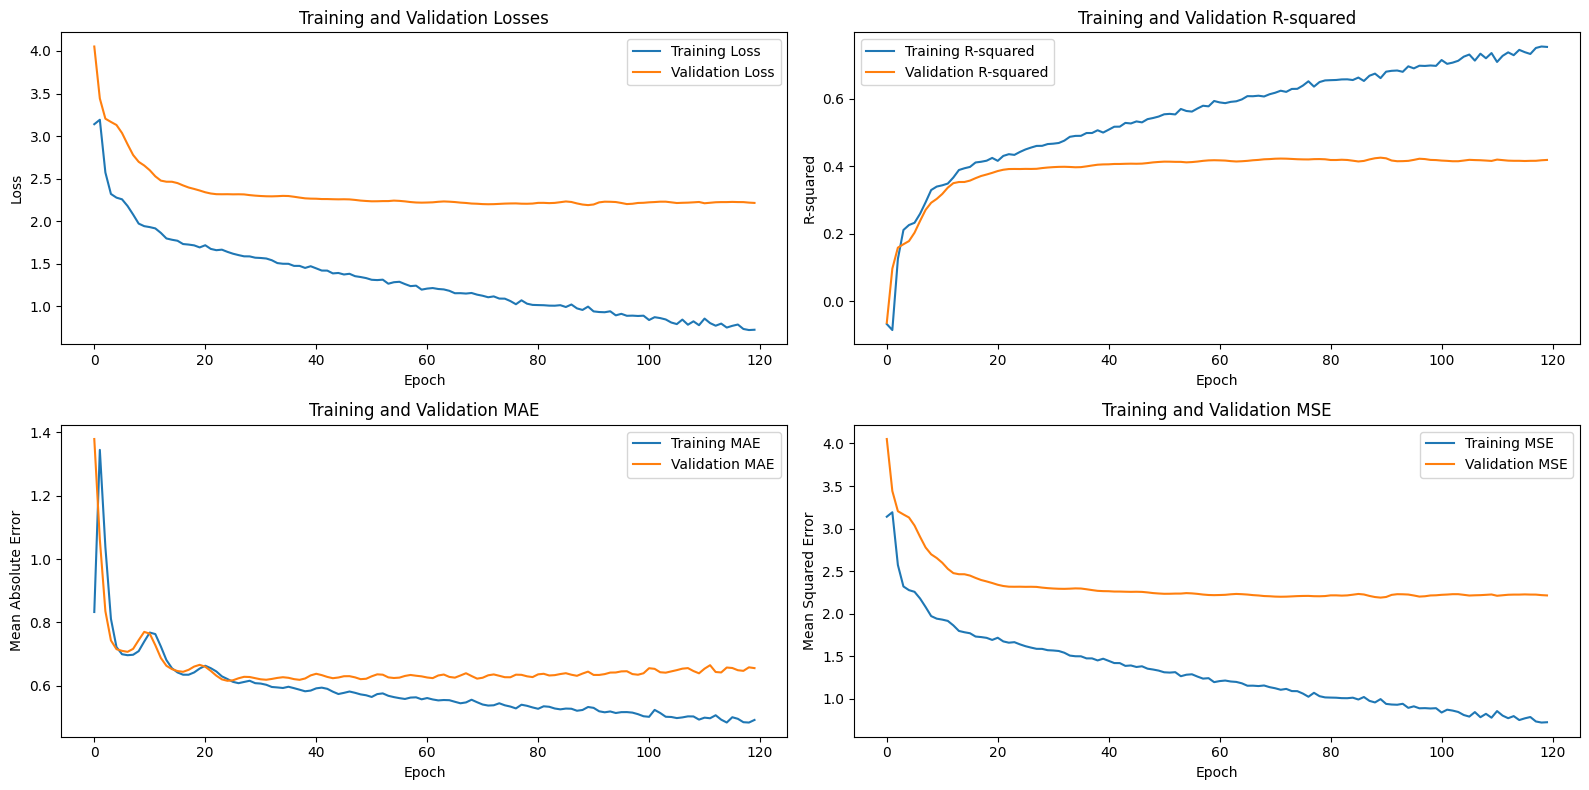

Test R-squared: 0.4009184493032325, Test MAE: 57.307640075683594, Test MSE: 13921.4326171875, Avg Test Residual: -0.5752679705619812


In [ ]:
from sklearn.preprocessing import RobustScaler
import torch
from torch import optim
from torch_geometric.nn import SAGEConv
import joblib
import os
import optuna
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
os.makedirs(drive_path, exist_ok=True)
model_path = os.path.join(drive_path, 'pegnn_model_PARIS.pth')
study_path = os.path.join(drive_path, 'optuna_study_pegnn_PARIS.pkl')
input_size_path = os.path.join(drive_path, 'input_feature_size_PARIS.pkl')

# Function to save and load the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model_class, path, in_channels, hidden_channels):
    model = model_class(in_channels, hidden_channels)
    model.load_state_dict(torch.load(path))
    return model

# Function to save and load input feature size
def save_input_feature_size(size, path):
    with open(path, 'wb') as f:
        joblib.dump(size, f)

def load_input_feature_size(path):
    with open(path, 'rb') as f:
        size = joblib.load(f)
    return size

# Create edges using k-nearest neighbors
def create_edges_knn(coordinates, k=15):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coordinates)
    distances, indices = nbrs.kneighbors(coordinates)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors:
            if i != neighbor:
                edge_index.append([i, neighbor])
                edge_index.append([neighbor, i])  # add both directions
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

# Learnable Positional Embeddings
class PositionalEncoding(torch.nn.Module):
    def __init__(self, num_positions, d_model):
        super(PositionalEncoding, self).__init__()
        self.position_embeddings = torch.nn.Parameter(torch.zeros(num_positions, d_model))

    def forward(self, positions):
        return self.position_embeddings[positions]

# PEGNN model definition with a single fully connected layer
class PEGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout_rate=0.5):
        super(PEGNN, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.out = torch.nn.Linear(hidden_channels, 1)  # Single fully connected layer with one output node

    def forward(self, x, edge_index):
        price_index = 1
        prices = x[:, price_index]

        # Mask out the node's own price during aggregation
        x_masked = x.clone()
        x_masked[:, price_index] = 0

        # Pass through the first convolutional layer with dropout
        x = self.conv1(x_masked, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Pass through the second convolutional layer
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Directly pass to the final output layer
        x = self.out(x)

        return x

d_model = 128

# Optuna objective function
def objective(trial):
    hidden_channels = trial.suggest_int('hidden_channels', 32, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    k = trial.suggest_int('k', 1, 150)  # Hyperparameter for k-nearest neighbors
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    edge_index_train = create_edges_knn(train_coords_pegnn, k)
    edge_index_val = create_edges_knn(val_coords_pegnn, k)
    edge_index_test = create_edges_knn(test_coords_pegnn, k)

    positional_encoding = PositionalEncoding(num_positions=train_coords_pegnn.shape[0], d_model=d_model)
    pos_enc_train = positional_encoding(torch.arange(train_coords_pegnn.shape[0]))
    pos_enc_val = positional_encoding(torch.arange(val_coords_pegnn.shape[0]))
    pos_enc_test = positional_encoding(torch.arange(test_coords_pegnn.shape[0]))

    x_train = torch.cat([torch.tensor(train_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_train], dim=1)
    x_val = torch.cat([torch.tensor(val_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_val], dim=1)
    x_test = torch.cat([torch.tensor(test_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_test], dim=1)

    model = PEGNN(in_channels=x_train.shape[1], hidden_channels=hidden_channels, dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # L2 regularization with weight_decay
    loss_fn = torch.nn.MSELoss()

    model.train()
    for epoch in tqdm(range(50), desc="Training PEGNN"):
        optimizer.zero_grad()
        out_train = model(x_train, edge_index_train)
        loss = loss_fn(out_train, y_train)
        loss.backward(retain_graph=True)
        optimizer.step()

    model.eval()
    with torch.no_grad():
        out_val = model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val)

    return val_loss.item()

# Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

# Save the study
with open(study_path, 'wb') as f:
    joblib.dump(study, f)

best_params = study.best_params
print("Best parameters: ", best_params)

# Final training with best parameters
edge_index_train = create_edges_knn(train_coords_pegnn, best_params['k'])
edge_index_val = create_edges_knn(val_coords_pegnn, best_params['k'])
edge_index_test = create_edges_knn(test_coords_pegnn, best_params['k'])

positional_encoding = PositionalEncoding(num_positions=train_coords_pegnn.shape[0], d_model=d_model)
pos_enc_train = positional_encoding(torch.arange(train_coords_pegnn.shape[0]))
pos_enc_val = positional_encoding(torch.arange(val_coords_pegnn.shape[0]))
pos_enc_test = positional_encoding(torch.arange(test_coords_pegnn.shape[0]))

x_train = torch.cat([torch.tensor(train_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_train], dim=1)
x_val = torch.cat([torch.tensor(val_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_val], dim=1)
x_test = torch.cat([torch.tensor(test_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_test], dim=1)

# Save input feature size
input_feature_size = x_train.shape[1]
save_input_feature_size(input_feature_size, input_size_path)

model = PEGNN(in_channels=input_feature_size, hidden_channels=best_params['hidden_channels'], dropout_rate=best_params['dropout_rate'])
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=1e-4)  # L2 regularization with weight_decay
loss_fn = torch.nn.MSELoss()

train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []
train_mae_scores = []
val_mae_scores = []
train_mse_scores = []
val_mse_scores = []

# Early stopping parameters
patience = 30
best_val_loss = float('inf')
patience_counter = 0

model.train()
for epoch in tqdm(range(500), desc="Final training"):
    optimizer.zero_grad()
    out_train = model(x_train, edge_index_train)
    loss = loss_fn(out_train, y_train)
    loss.backward(retain_graph=True)
    optimizer.step()
    train_losses.append(loss.item())

    y_train_np = y_train.detach().numpy()
    out_train_np = out_train.detach().numpy()
    train_r2 = r2_score(y_train_np, out_train_np)
    train_mae = mean_absolute_error(y_train_np, out_train_np)
    train_mse = mean_squared_error(y_train_np, out_train_np)
    train_r2_scores.append(train_r2)
    train_mae_scores.append(train_mae)
    train_mse_scores.append(train_mse)

    print(f'Epoch {epoch + 1}, Training Loss: {loss.item()}, Training R-squared: {train_r2}, Training MAE: {train_mae}, Training MSE: {train_mse}')

    model.eval()
    with torch.no_grad():
        out_val = model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val)
        val_losses.append(val_loss.item())

        y_val_np = y_val.detach().numpy()
        out_val_np = out_val.detach().numpy()
        val_r2 = r2_score(y_val_np, out_val_np)
        val_mae = mean_absolute_error(y_val_np, out_val_np)
        val_mse = mean_squared_error(y_val_np, out_val_np)
        val_r2_scores.append(val_r2)
        val_mae_scores.append(val_mae)
        val_mse_scores.append(val_mse)

    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss.item()}, Validation R-squared: {val_r2}, Validation MAE: {val_mae}, Validation MSE: {val_mse}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        save_model(model, model_path)
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break

    model.train()

# Plotting
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

plt.subplot(2, 2, 2)
plt.plot(train_r2_scores, label='Training R-squared')
plt.plot(val_r2_scores, label='Validation R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.legend()
plt.title('Training and Validation R-squared')

plt.subplot(2, 2, 3)
plt.plot(train_mae_scores, label='Training MAE')
plt.plot(val_mae_scores, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')

plt.subplot(2, 2, 4)
plt.plot(train_mse_scores, label='Training MSE')
plt.plot(val_mse_scores, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation MSE')

plt.tight_layout()
plt.show()

# Rescale predictions and targets for final evaluation
model.eval()
with torch.no_grad():
    out_train = model(x_train, edge_index_train)
    out_val = model(x_val, edge_index_val)
    out_test = model(x_test, edge_index_test)

# Inverse transform the predictions and actual values
out_train_rescaled = scaler.inverse_transform(out_train.numpy())
y_train_rescaled = scaler.inverse_transform(y_train.numpy())

out_val_rescaled = scaler.inverse_transform(out_val.numpy())
y_val_rescaled = scaler.inverse_transform(y_val.numpy())

out_test_rescaled = scaler.inverse_transform(out_test.numpy())
y_test_rescaled = scaler.inverse_transform(y_test.numpy())

# Compute metrics on the original scale
train_r2 = r2_score(y_train_rescaled, out_train_rescaled)
train_mae = mean_absolute_error(y_train_rescaled, out_train_rescaled)
train_mse = mean_squared_error(y_train_rescaled, out_train_rescaled)

val_r2 = r2_score(y_val_rescaled, out_val_rescaled)
val_mae = mean_absolute_error(y_val_rescaled, out_val_rescaled)
val_mse = mean_squared_error(y_val_rescaled, out_val_rescaled)

test_r2 = r2_score(y_test_rescaled, out_test_rescaled)
test_mae = mean_absolute_error(y_test_rescaled, out_test_rescaled)
test_mse = mean_squared_error(y_test_rescaled, out_test_rescaled)
test_residuals_avg = np.mean(y_test_rescaled - out_test_rescaled)
print(f'Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}, Avg Test Residual: {test_residuals_avg}')


extra reporting metrics


Test Loss: 1.972992181777954, Test R-squared: 0.4009184493032325, Test MAE: 57.307640075683594, Test MSE: 13921.4326171875


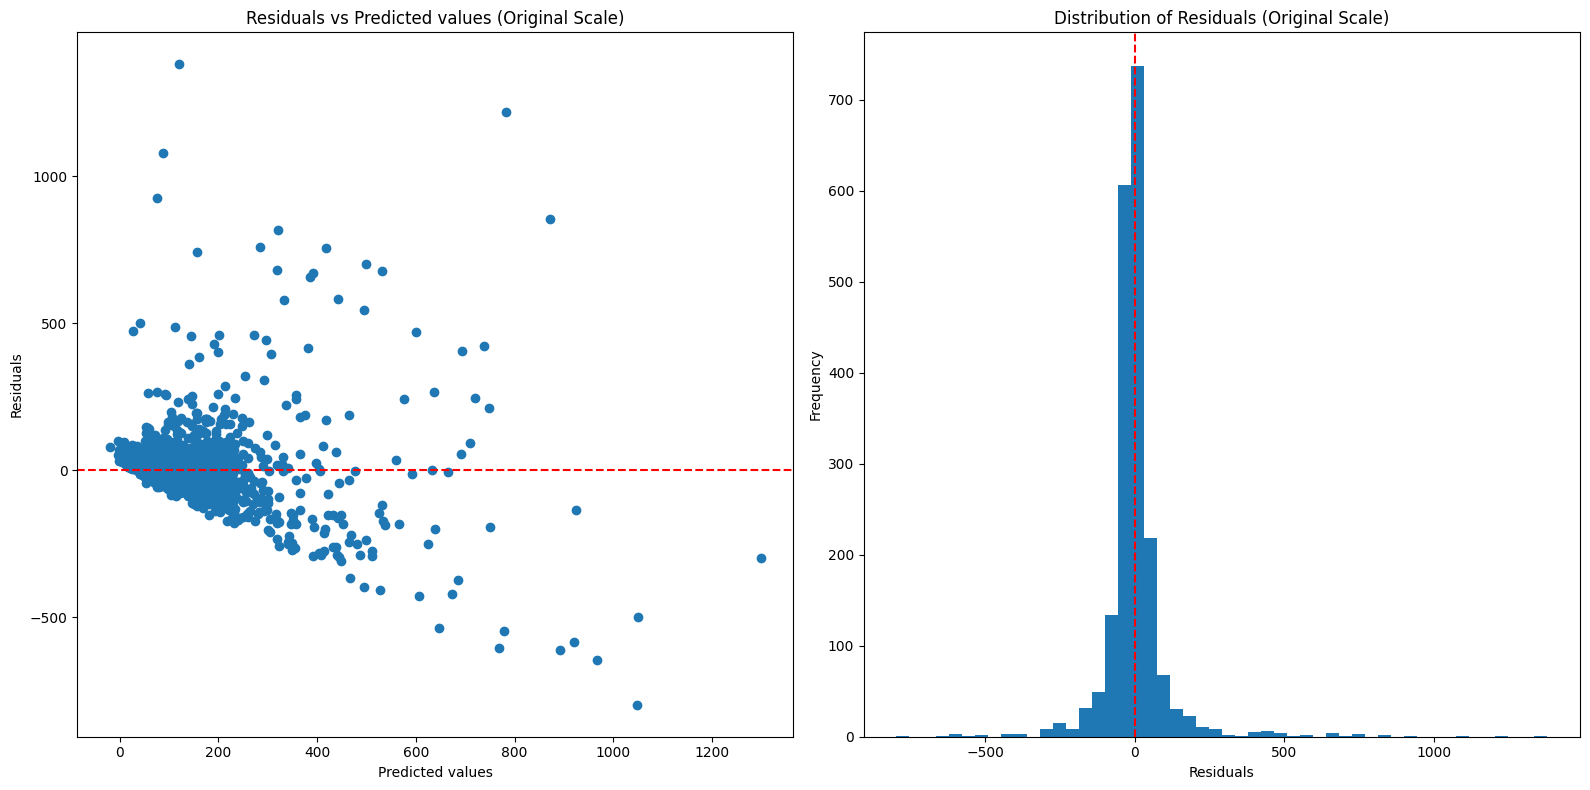

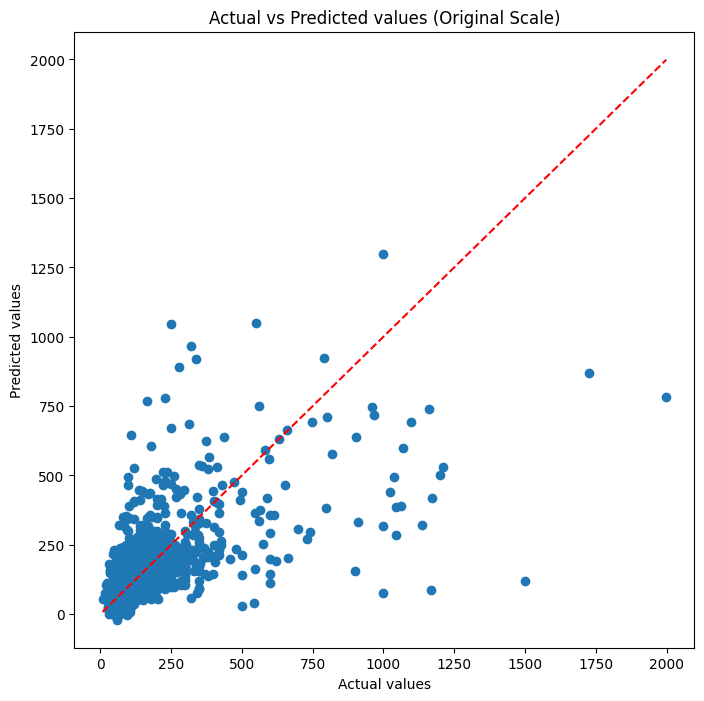

In [ ]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    out_test = model(x_test, edge_index_test)
    test_loss = loss_fn(out_test, y_test)
    y_test_np = y_test.detach().numpy()
    out_test_np = out_test.detach().numpy()

# Inverse transform the predictions and actual values
y_test_rescaled = scaler.inverse_transform(y_test_np)
out_test_rescaled = scaler.inverse_transform(out_test_np)

# Calculate evaluation metrics on the original scale
test_r2 = r2_score(y_test_rescaled, out_test_rescaled)
test_mae = mean_absolute_error(y_test_rescaled, out_test_rescaled)
test_mse = mean_squared_error(y_test_rescaled, out_test_rescaled)

print(f'Test Loss: {test_loss.item()}, Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}')

# Calculate residuals in the original scale
residuals_rescaled = y_test_rescaled - out_test_rescaled

# Plotting residuals
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.scatter(out_test_rescaled, residuals_rescaled)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values (Original Scale)')
plt.axhline(0, color='red', linestyle='--')

plt.subplot(1, 2, 2)
plt.hist(residuals_rescaled, bins=50)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Original Scale)')
plt.axvline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Plotting predicted vs actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test_rescaled, out_test_rescaled)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted values (Original Scale)')
plt.plot([min(y_test_rescaled), max(y_test_rescaled)], [min(y_test_rescaled), max(y_test_rescaled)], color='red', linestyle='--')
plt.show()


Text(0.5, 1.0, 'Heatmap of Predicted Prices')

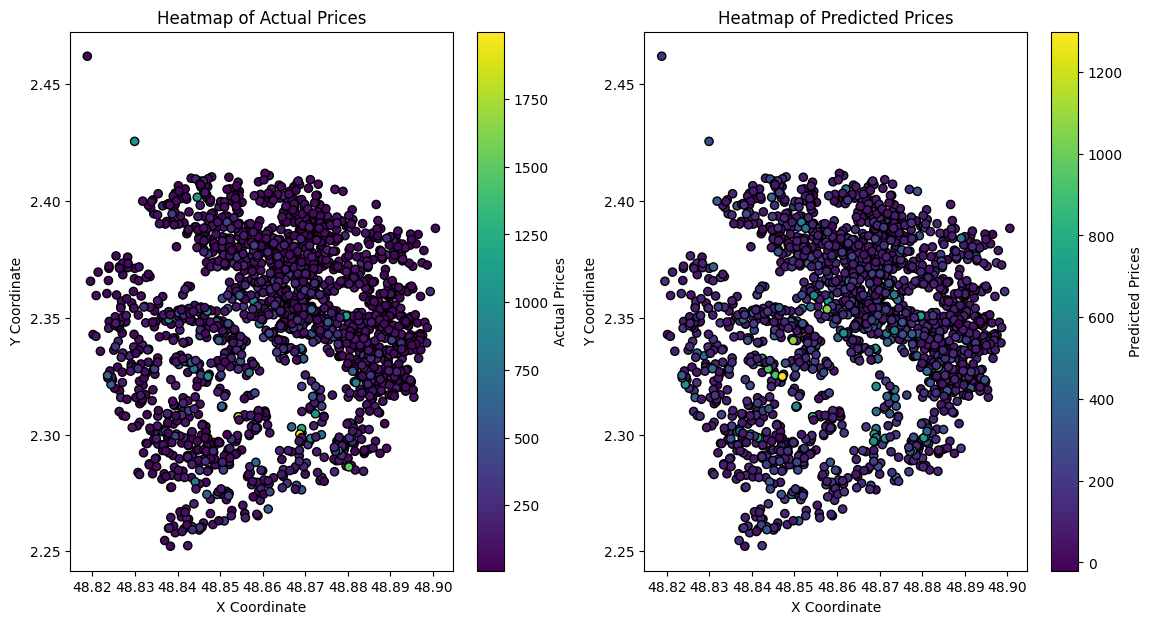

In [ ]:
import seaborn as sns

# Assuming 'coords_np' contains the coordinates and 'scaler' is used for inverse transformation
coords_np = np.array(test_coords_pegnn)

# Rescale the actual and predicted prices to original scale
y_test_rescaled = scaler.inverse_transform(y_test_np)
out_test_rescaled = scaler.inverse_transform(out_test_np)
residuals_rescaled = y_test_rescaled - out_test_rescaled

plt.figure(figsize=(21, 7))

# Heatmap of Actual Prices
plt.subplot(1, 3, 1)
plt.scatter(coords_np[:, 0], coords_np[:, 1], c=y_test_rescaled.flatten(), cmap='viridis', s=35, edgecolor='k')
plt.colorbar(label='Actual Prices')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Actual Prices')

# Heatmap of Predicted Prices
plt.subplot(1, 3, 2)
plt.scatter(coords_np[:, 0], coords_np[:, 1], c=out_test_rescaled.flatten(), cmap='viridis', s=35, edgecolor='k')
plt.colorbar(label='Predicted Prices')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Predicted Prices')


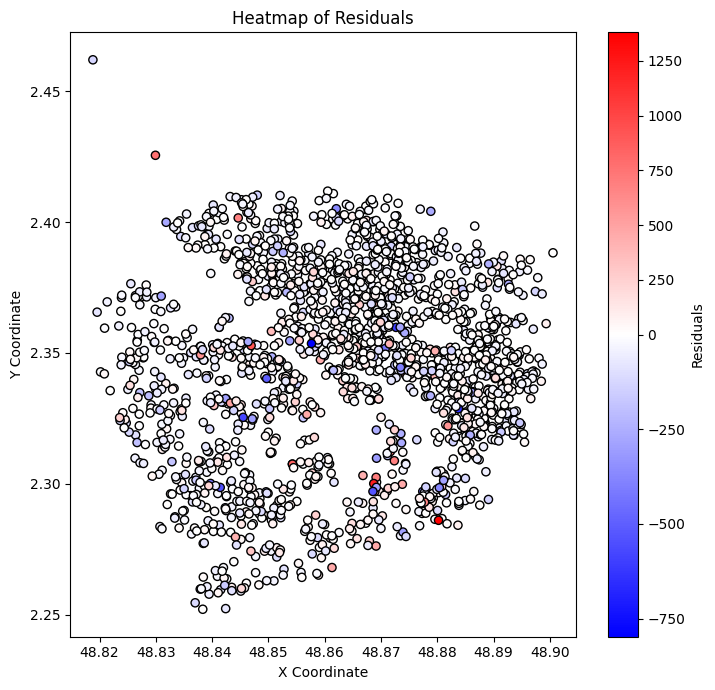

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm



# Define a custom colormap with 0 as white
cmap = LinearSegmentedColormap.from_list('custom_coolwarm',
                                         [(0, 'blue'),
                                          (0.5, 'white'),
                                          (1, 'red')], N=256)

# Normalize the data so that 0 maps to white
norm = TwoSlopeNorm(vmin=residuals_rescaled.min(), vcenter=0, vmax=residuals_rescaled.max())

# Create the plot
plt.figure(figsize=(21, 7))

# Heatmap of Residuals
plt.subplot(1, 3, 3)
sc = plt.scatter(coords_np[:, 0], coords_np[:, 1], c=residuals_rescaled.flatten(), cmap=cmap, norm=norm, s=35, edgecolor='k')
plt.colorbar(sc, label='Residuals')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Residuals')

plt.tight_layout()
plt.show()


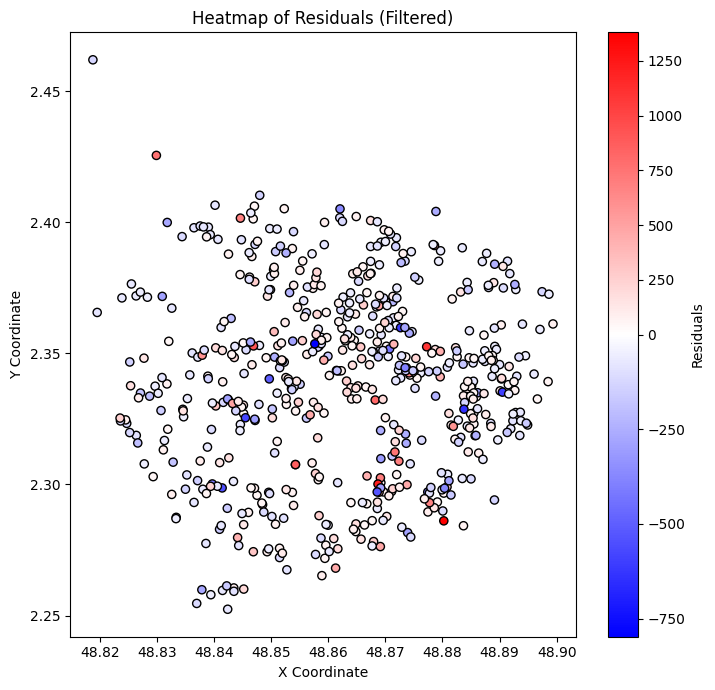

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# Assuming residuals_rescaled and coords_np are already defined

# Define a custom colormap with 0 as white
cmap = LinearSegmentedColormap.from_list('custom_coolwarm',
                                         [(0, 'blue'),
                                          (0.5, 'white'),
                                          (1, 'red')], N=256)

# Normalize the data so that 0 maps to white
norm = TwoSlopeNorm(vmin=residuals_rescaled.min(), vcenter=0, vmax=residuals_rescaled.max())

# Filter out residuals between -50 and 50
mask = (residuals_rescaled < -50) | (residuals_rescaled > 50)
filtered_coords = coords_np[mask.flatten()]
filtered_residuals = residuals_rescaled[mask]

# Create the plot
plt.figure(figsize=(21, 7))

# Heatmap of Residuals
plt.subplot(1, 3, 3)
sc = plt.scatter(filtered_coords[:, 0], filtered_coords[:, 1], c=filtered_residuals.flatten(), cmap=cmap, norm=norm, s=35, edgecolor='k')
plt.colorbar(sc, label='Residuals')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Residuals (Filtered)')

plt.tight_layout()
plt.show()


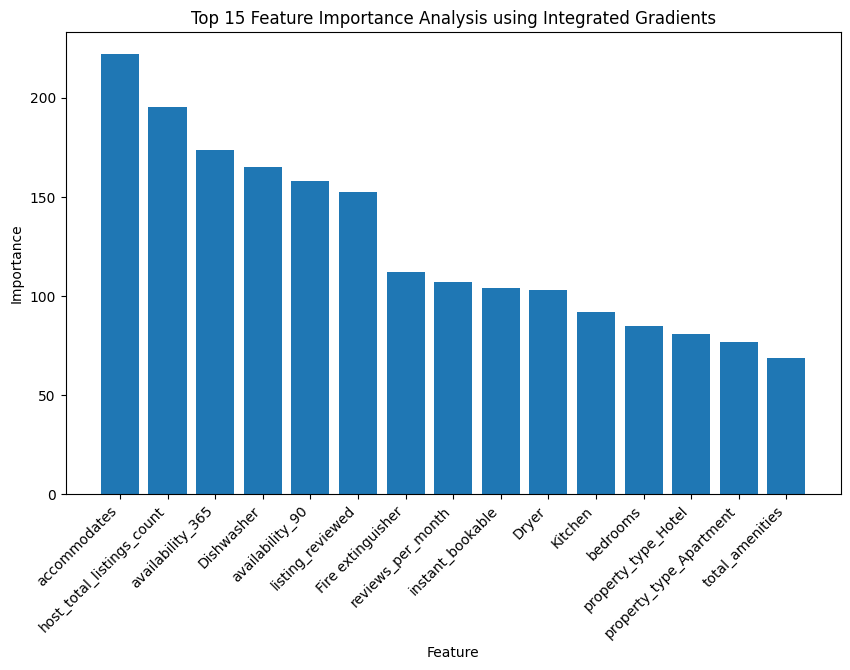

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

feature_names = train_features_pegnn.columns.tolist()

def integrated_gradients(model, inputs, edge_index, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(inputs)

    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads = []

    for input_ in scaled_inputs:
        input_ = Variable(input_, requires_grad=True)
        output = model(input_, edge_index)
        target = output[:, target_class].sum()
        target.backward(retain_graph=True)
        grads.append(input_.grad.cpu().detach().numpy())

    grads = np.array(grads)
    avg_grads = np.mean(grads[:-1], axis=0)
    integrated_grads = (inputs.cpu().detach().numpy() - baseline.cpu().detach().numpy()) * avg_grads

    return integrated_grads

# Assuming model, x_test, edge_index_test, y_test, and feature_names are already defined

inputs = x_test  # Use all node features in the graph
baseline = torch.zeros_like(inputs)
target_class = 0  # Assuming the target class is the first output
integrated_grads = integrated_gradients(model, inputs, edge_index_test, target_class, baseline)

overall_feature_importances = np.sum(integrated_grads, axis=0)

# Get the top 15 features
top_features_idx = np.argsort(overall_feature_importances)[-15:][::-1]
top_features = [feature_names[i] for i in top_features_idx]
top_importances = overall_feature_importances[top_features_idx]

# Visualize top 15 feature importances
plt.figure(figsize=(10, 6))
plt.bar(top_features, top_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 15 Feature Importance Analysis using Integrated Gradients')
plt.xticks(rotation=45, ha='right')
plt.show()


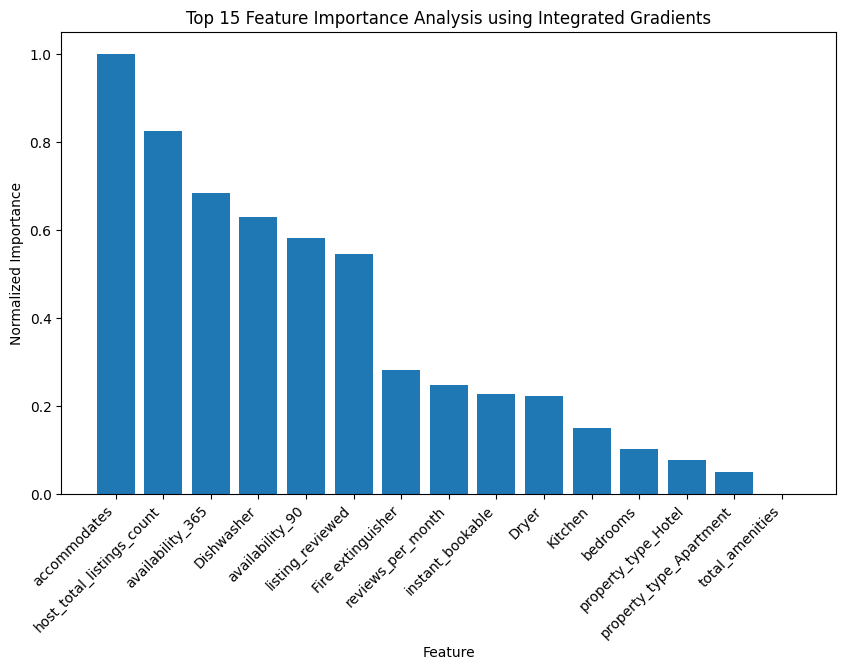

Top 15 Feature Importances (Normalized):
accommodates: 1.0000
host_total_listings_count: 0.8254
availability_365: 0.6838
Dishwasher: 0.6290
availability_90: 0.5807
listing_reviewed: 0.5463
Fire extinguisher: 0.2815
reviews_per_month: 0.2476
instant_bookable: 0.2283
Dryer: 0.2218
Kitchen: 0.1507
bedrooms: 0.1026
property_type_Hotel: 0.0768
property_type_Apartment: 0.0502
total_amenities: 0.0000


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

# Assuming train_features_pegnn, model, x_test, edge_index_test, and y_test are already defined

feature_names = train_features_pegnn.columns.tolist()

def integrated_gradients(model, inputs, edge_index, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(inputs)

    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads = []

    for input_ in scaled_inputs:
        input_ = Variable(input_, requires_grad=True)
        output = model(input_, edge_index)
        target = output[:, target_class].sum()
        target.backward(retain_graph=True)
        grads.append(input_.grad.cpu().detach().numpy())

    grads = np.array(grads)
    avg_grads = np.mean(grads[:-1], axis=0)
    integrated_grads = (inputs.cpu().detach().numpy() - baseline.cpu().detach().numpy()) * avg_grads

    return integrated_grads

# Get the inputs and baseline for the entire graph
inputs = x_test  # Use all node features in the graph
baseline = torch.zeros_like(inputs)

# Compute Integrated Gradients for each node in the graph
target_class = 0  # Assuming the target class is the first output
integrated_grads = integrated_gradients(model, inputs, edge_index_test, target_class, baseline)

# Summing up the attributions for all nodes to get overall feature importances
overall_feature_importances = np.sum(integrated_grads, axis=0)

# Get the top 15 features
top_features_idx = np.argsort(overall_feature_importances)[-15:][::-1]
top_features = [feature_names[i] for i in top_features_idx]
top_importances = overall_feature_importances[top_features_idx]

# Normalize the top 15 feature importances to the range [0, 1]
min_importance = np.min(top_importances)
max_importance = np.max(top_importances)
normalized_importances = (top_importances - min_importance) / (max_importance - min_importance)

# Visualize top 15 feature importances
plt.figure(figsize=(10, 6))
plt.bar(top_features, normalized_importances)
plt.xlabel('Feature')
plt.ylabel('Normalized Importance')
plt.title('Top 15 Feature Importance Analysis using Integrated Gradients')
plt.xticks(rotation=45, ha='right')
plt.show()

# Create a DataFrame for the top 15 features and their normalized importances
feature_importances_df = pd.DataFrame({
    'Feature': top_features,
    'Normalized Importance': normalized_importances
})

# Save the DataFrame to a CSV file
# Specify the path in Google Drive where you want to save the files
path = '/content/drive/My Drive/THESIS/'

# Save the processed data to CSV files
feature_importances_df.to_csv(path + 'feature_importances_with_lstm_london.csv', index=False)
# Display the list of top 15 features with their normalized importances
print("Top 15 Feature Importances (Normalized):")
for feature, importance in zip(top_features, normalized_importances):
    print(f"{feature}: {importance:.4f}")